## Exercice colle "Modéliser le flou"


In [1]:
from PIL import Image
import cv2
import numpy as np
import os
import urllib.request
import requests

In [2]:
def calcule_taille(D:float, fprime:float, OA:float, OE:float, AB:float) -> tuple:
    """
    Entrées:
        D: diamètre de la lentille (en m)
        fprime: 0 distance focale de la lentille (en m)
        OA: distance lentille-objet (en m)
        OE: distance lentille-écran (en m)
        AB: taille objet (en m)
    Sorties:
        tuple (H,d) avec:
        H: hauteur de la représentation de l'objet sur l'écran (en m)
        d: diamètre des tâches sur l'écran (en m)
    """
    # CODE À COMPLÉTER
    return H, d

In [3]:
def creation_masque_tache(rayon, hauteur, largeur):
    """Crée un masque pour une tache circulaire."""
    Y, X = np.ogrid[:hauteur, :largeur]
    dist_au_centre = np.sqrt((X - largeur // 2) ** 2 + (Y - hauteur // 2) ** 2)
    mask = dist_au_centre <= rayon
    return mask.astype(np.float32)  # Retourne un masque de type float32

def creation_masque_circulaire(hauteur, largeur, centre=None, rayon=None):
    if centre is None: # on détermine le milieu de l'image
        centre = (int(largeur/2), int(hauteur/2))
    if rayon is None: # on détermine la plus petite distance entre le centre et les bords de l'image
        rayon = min(centre[0], centre[1], largeur-centre[0], hauteur-centre[1])
    Y, X = np.ogrid[:hauteur, :largeur]
    dist_au_centre = np.sqrt((X - centre[0])**2 + (Y-centre[1])**2)
    mask = dist_au_centre <= rayon
    return mask

def image_from_url(adresse):
    headers = {
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.3'}
    response = requests.get(adresse, headers=headers)
    if response.status_code == 200:
        with open('image', 'wb') as file:
            file.write(response.content)
    else:
        print("Impossible de récupérer l'image: Statut", response.status_code)
    image = Image.open('image').convert("RGBA")
    return image

def vision_ecran(adresse_image, diametre_lentille, fprime, OA, OE, AB):
    #original = Image.open(adresse_image).convert("RGBA")
    original = image_from_url(adresse_image)
    largeur_origine, hauteur_origine = original.size
    original_array = np.array(original, dtype=np.float32)

    taille_image, diametre_tache = calcule_taille(diametre_lentille, fprime, OA, OE, AB)

    # Calculs pour convertir la taille de l'écran A4 en pixels
    largeur_A4_px = 800
    A4_ratio = 29.7 / 21.0
    hauteur_A4_px = int(largeur_A4_px * A4_ratio)

    if largeur_origine < hauteur_origine:
        diametre_medaillon_px = int(largeur_A4_px * (taille_image / 0.21))
        hauteur_nv = int(hauteur_origine * (diametre_medaillon_px / largeur_origine))
    else:
        largeur_A4_px,hauteur_A4_px = hauteur_A4_px,largeur_A4_px
        diametre_medaillon_px = int(hauteur_A4_px * (taille_image / 0.21))
        hauteur_nv = int(largeur_origine * (diametre_medaillon_px / hauteur_origine))

    if largeur_origine < hauteur_origine:
        img_echelle = cv2.resize(original_array, (diametre_medaillon_px, hauteur_nv), interpolation=cv2.INTER_LINEAR)
    else:
        img_echelle = cv2.resize(original_array, (hauteur_nv,diametre_medaillon_px), interpolation=cv2.INTER_LINEAR)

    img_echelle = cv2.flip(img_echelle, -1)

    rayon = max(1, int(diametre_tache * largeur_A4_px / 0.21))
    masque_tache = creation_masque_tache(rayon, 2*rayon+1, 2*rayon+1)
    masque_tache /= masque_tache.sum()

    img_floue = cv2.filter2D(img_echelle, -1, masque_tache)
    img_floue = np.clip(img_floue, 0, 255)

    # Appliquer le masque circulaire à l'image floutée
    if largeur_origine < hauteur_origine:
        masque_circulaire = creation_masque_circulaire(hauteur_nv, diametre_medaillon_px, rayon=diametre_medaillon_px//2)
    else:
        masque_circulaire = creation_masque_circulaire(diametre_medaillon_px, hauteur_nv, rayon=diametre_medaillon_px//2)
    medaillon_flou = np.zeros_like(img_floue)
    for i in range(4):  # Appliquer le masque à chaque canal (RGBA)
        medaillon_flou[:, :, i] = img_floue[:, :, i] * masque_circulaire

    # Création de l'image finale avec un fond blanc de la taille A4
    final_array = np.ones((hauteur_A4_px, largeur_A4_px, 4), dtype=np.float32) * 255  # RGBA white background

    # Calcul du centre pour le médaillon
    if largeur_origine < hauteur_origine:
        centre_x = (largeur_A4_px - diametre_medaillon_px) // 2
        centre_y = (hauteur_A4_px - hauteur_nv) // 2
    else:
        centre_x = (largeur_A4_px - hauteur_nv) // 2
        centre_y = (hauteur_A4_px - diametre_medaillon_px) // 2
    # Superposition de l'image floutée circulaire sur le fond blanc
    # En s'assurant que le médaillon ne dépasse pas les dimensions de l'écran A4
    haut_y = max(centre_y, 0)
    gauche_x = max(centre_x, 0)
    if largeur_origine < hauteur_origine:
        bas_y = min(centre_y + hauteur_nv, hauteur_A4_px)  # Limite inférieure dans la plage de l'écran A4
        droit_x = min(centre_x + diametre_medaillon_px, largeur_A4_px)  # Limite droite dans la plage de l'écran A4
    else:
        bas_y = min(centre_y + diametre_medaillon_px, hauteur_A4_px)
        droit_x = min(centre_x + hauteur_nv, largeur_A4_px)

    # Ajustement de l'image floutée circulaire pour correspondre à l'espace disponible
    medaillon_flou_ajuste = medaillon_flou[(haut_y-centre_y):(bas_y-centre_y),(gauche_x-centre_x):(droit_x-centre_x)]

    # Copie de l'image floutée circulaire dans l'écran A4
    final_array[haut_y:bas_y, gauche_x:droit_x] = medaillon_flou_ajuste

    # Parcourir le canal alpha (3) pour remplacer les valeurs 0 (transparentes) par 255 (opacité complète)
    canal_alpha = final_array[:, :, 3]
    masque_transparent = (canal_alpha == 0)
    final_array[masque_transparent] = [255, 255, 255, 255]  # RGBA pour blanc opaque

    # Conversion en image PIL et sauvegarde
    image_finale = Image.fromarray(final_array.astype('uint8'), "RGBA")
    image_finale.save('floue.png')

    return image_finale

In [4]:
adresse = "https://images.ctfassets.net/b85ozb2q358o/51136491ea90baa41725f11797ae422679b93a56cd4a467a78bae40f41a9ad68/8747ba01f958e63a83decf641cb8e894/image.png"
#adresse = 'https://presentationssite.github.io/logocolle.png'
#adresse = 'https://www.ooinvestir.fr/sites/ooinvestir/files/2021-03/ooinvestir-quartiers-la-rochelle-pinel_1000x667.jpg'
#adresse = "ar.png"

In [5]:
diametre_lentille = 0.15
fprime = 0.1
OA = -0.3
OE = 0.15
AB = 0.15

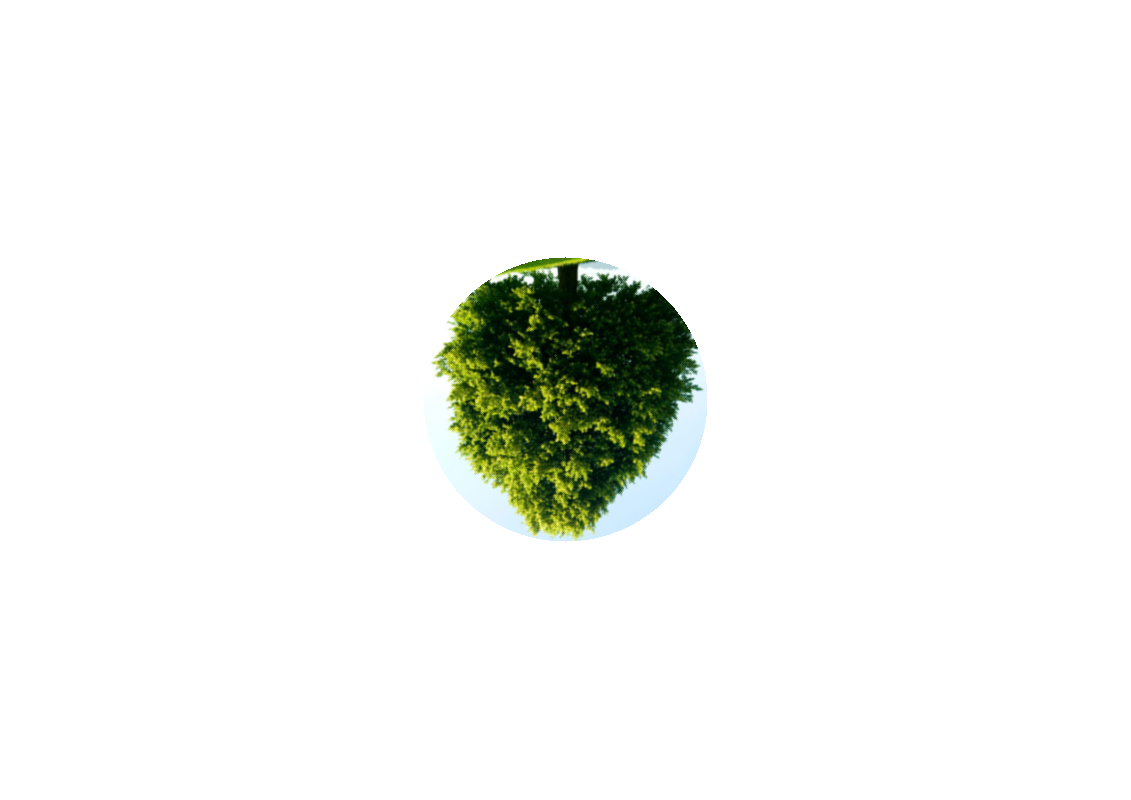

In [6]:
vision_ecran(adresse, diametre_lentille, fprime, OA, OE, AB)

In [7]:
def generate_images(input_image_path, diametre_lentille, fprime, OA, AB, start_OE, end_OE, step_OE):
    """Génère et enregistre des images pour différentes positions de l'écran."""
    output_dir = 'floues'
    # Crée le répertoire s'il n'existe pas
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    count = 1
    for OE in np.arange(start_OE, end_OE, step_OE):
        output_image = vision_ecran(input_image_path, diametre_lentille, fprime, OA, OE, AB)
        output_path = os.path.join(output_dir, f"image_{str(count).zfill(3)}.png")
        print(f"Saving image to {output_path}")
        output_image.save(output_path)
        count += 1

In [8]:
generate_images(adresse,diametre_lentille,fprime,OA,AB,0.01,0.3,0.002)

Saving image to floues/image_001.png
Saving image to floues/image_002.png
Saving image to floues/image_003.png
Saving image to floues/image_004.png
Saving image to floues/image_005.png
Saving image to floues/image_006.png
Saving image to floues/image_007.png
Saving image to floues/image_008.png
Saving image to floues/image_009.png
Saving image to floues/image_010.png
Saving image to floues/image_011.png
Saving image to floues/image_012.png
Saving image to floues/image_013.png
Saving image to floues/image_014.png
Saving image to floues/image_015.png
Saving image to floues/image_016.png
Saving image to floues/image_017.png
Saving image to floues/image_018.png
Saving image to floues/image_019.png
Saving image to floues/image_020.png
Saving image to floues/image_021.png
Saving image to floues/image_022.png
Saving image to floues/image_023.png
Saving image to floues/image_024.png
Saving image to floues/image_025.png
Saving image to floues/image_026.png
Saving image to floues/image_027.png
S

In [9]:
!ffmpeg -r 30 -i floues/image_%03d.png -vf "scale=ceil(iw/2)*2:ceil(ih/2)*2" -vcodec libx264 -crf 25 -pix_fmt yuv420p movie.mp4

ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

In [10]:
from IPython.display import HTML
from base64 import b64encode

# Charger la vidéo et définir le MIME type approprié
video_path = 'movie.mp4'
mp4 = open(video_path,'rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()

# HTML pour afficher la vidéo
HTML("""
<video width=600 controls>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)